In [8]:
bIsGoogleColab = False

In [9]:
if(bIsGoogleColab):
    !umount ./ramdisk
    !mkdir ./ramdisk
    !mount -t tmpfs -o size=5g tmpfs ./ramdisk
    !mkdir ./ramdisk/augmented
    !gdown 1vcJqO1ZChISHubGykn5hQSQGW0RecwdT
    !tar -xf archive_handwrite.tar.xz -C ./ramdisk/
else:
    !sudo -S umount ./ramdisk < ./mypassword.txt
    !mkdir ./ramdisk
    !sudo -S mount -t tmpfs -o size=5g tmpfs ./ramdisk < ./mypassword.txt
    !mkdir ./ramdisk/augmented
    !cp -r archive_handwrite ./ramdisk

[sudo] password for hu: mkdir: cannot create directory ‘./ramdisk’: File exists
[sudo] password for hu: 

In [10]:
epochs = 10
batch_size = 8
validation_radio = 0.3

In [11]:
import os
import random
import math
import shutil

base_dir = './ramdisk/archive_handwrite'
train_dir = os.path.join(base_dir,'Train')
test_dir = os.path.join(base_dir, 'Test')
validation_dir = os.path.join(base_dir, 'Validation')

#create validation folder
os.mkdir(validation_dir)

dir_list = os.listdir(train_dir)
for symb_dir in dir_list:
    train_symb_dir = os.path.join(train_dir, symb_dir)
    val_symb_dir = os.path.join(validation_dir, symb_dir)

    #select the val file
    train_file_list = os.listdir(train_symb_dir)
    file_num = len(train_file_list)
    val_file_num = math.floor(file_num * validation_radio)
    val_file_list = random.sample(train_file_list, val_file_num)
    #print(symb_dir)
    #print(val_file_list)

    #create symbol dir in validation folder
    os.mkdir(val_symb_dir)
    #move selected file to val symbol dir
    for val_file in val_file_list:
        val_file_orig_path = os.path.join(train_symb_dir, val_file)
        shutil.move(val_file_orig_path, val_symb_dir)




In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-05-27 08:01:47.423054: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 08:01:47.576616: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 08:01:47.578660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 08:01:48.671420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 15,
							width_shift_range = 0.1,
							height_shift_range = 0.1,
							shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = False,)

In [15]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (32, 32),
							batch_size = batch_size,
							class_mode ='categorical',
                            color_mode="grayscale",
							#save_to_dir= './ramdisk/augmented',   #not save, make it faster
							#save_prefix='aug',
							#save_format='png'
							)

Found 583844 images belonging to 39 classes.


In [17]:
validation_generator = validation_datagen.flow_from_directory(
							validation_dir,
							target_size = (32, 32),
							batch_size = batch_size,
							class_mode ='categorical',
                            color_mode="grayscale",
							#save_to_dir= './ramdisk/augmented',   #not save, make it faster
							#save_prefix='aug',
							#save_format='png'
							)

Found 250192 images belonging to 39 classes.


<Figure size 640x480 with 0 Axes>

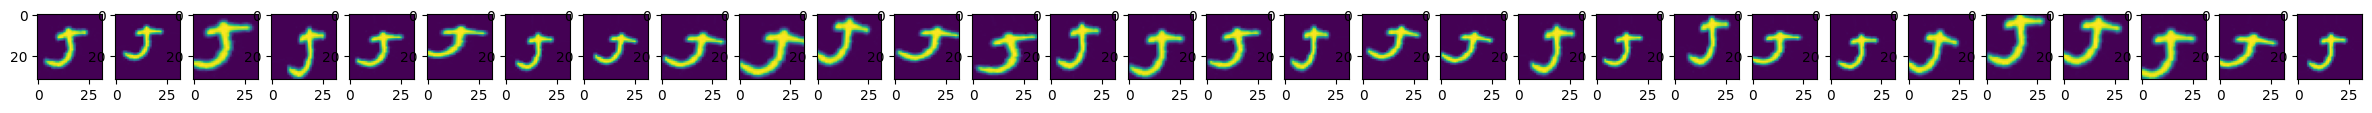

In [ ]:
plt.figure()

image_num = 30

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, image_num, figsize=(30, 8)) 

for i in range(image_num) :
  axarr[i].imshow(train_generator[40][0][0])

In [18]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
						
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (32,32,1)))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(39,activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        100       
                                                                 
 flatten (Flatten)           (None, 9000)              0         
                                                                 
 dense (Dense)               (None, 256)               2304256   
                                                                 
 dense_1 (Dense)             (None, 39)                10023     
                                                                 
Total params: 2,314,379
Trainable params: 2,314,379
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
						train_generator, 
                        steps_per_epoch = train_generator.n//batch_size,
						epochs = epochs,
                        validation_data = validation_generator,
                        #validation_steps = 
                        )

Epoch 1/10


2023-05-27 08:03:16.668341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1029/72980 [..............................] - ETA: 14:16 - loss: 0.1983 - acc: 0.0771

KeyboardInterrupt: 

In [ ]:
model.save('./ramdisk/simple_model.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()